In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torchvision import datasets, transforms
from torchvision import models

from torch.utils.data import Dataset, DataLoader
from PIL import Image

from tqdm import tqdm
from utils import to_numpy, show_img


#### SETUP DEVICE AGNOSTIC CODE

In [3]:
!nvidia-smi 2>&1 | grep -i "cuda"

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |


'cuda'

#### DOWNLOAD DATA

In [4]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_train = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

])


In [5]:
train_datasets = datasets.CIFAR10(root='../data', train=True, download=True, transform=transform_train)
test_datasets = datasets.CIFAR10(root='../data', train=False, download=True, transform=transform_test)


100%|██████████| 170M/170M [00:16<00:00, 10.1MB/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


In [6]:
len(train_datasets)

50000

In [7]:
BATCH_SIZE = 64

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
MODEL_OUTPUT_SHAPE = len(classes)

train_loader = DataLoader(train_datasets, batch_size=BATCH_SIZE, num_workers=2, shuffle=True)
test_loader = DataLoader(test_datasets, batch_size = BATCH_SIZE, num_workers=2)

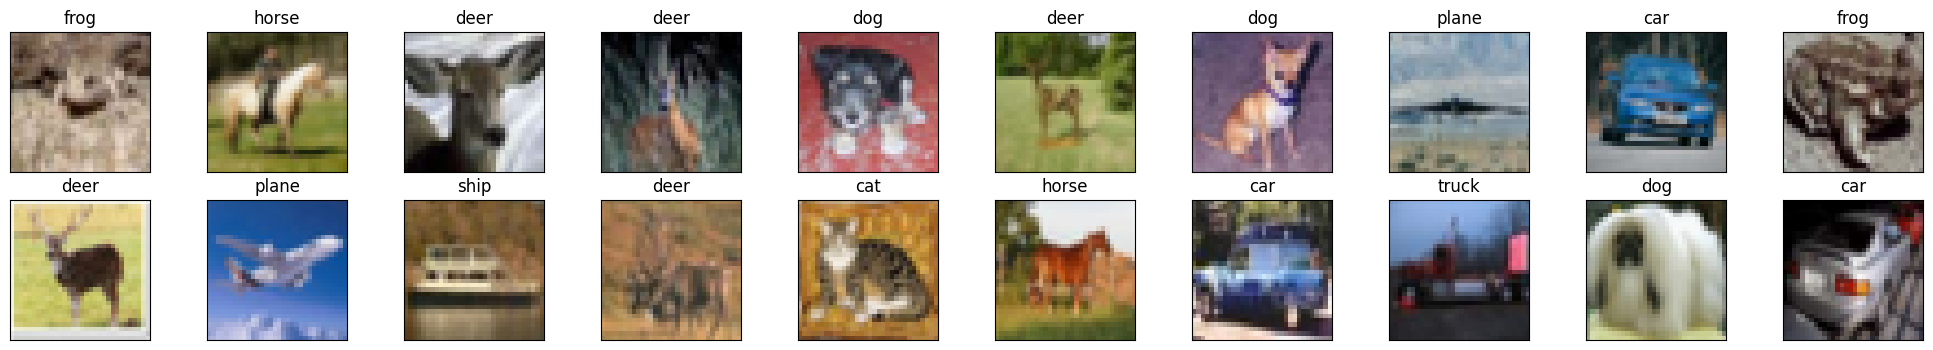

In [8]:
dataiter = iter(train_loader)

images, labels = next(dataiter)
fig = plt.figure(figsize=(25,4))

for i in range(20):
    ax = fig.add_subplot(2, 10, i+1, xticks = [], yticks = [])
    plt.imshow(to_numpy(images[i]))
    ax.set_title(classes[labels[i].item()])


In [9]:
train_features_batch, train_labels_batch = next(iter(train_loader))

train_features_batch.shape, train_labels_batch.shape

(torch.Size([64, 3, 32, 32]), torch.Size([64]))

#### DEMO FLATTEN LAYER

In [10]:
flatten_layer = nn.Flatten()
X = train_features_batch[0]
output = flatten_layer(X)

X.shape, output.shape

(torch.Size([3, 32, 32]), torch.Size([3, 1024]))

In [11]:
flatten_layer = nn.Flatten()
output_batch = flatten_layer(train_features_batch)

output_batch.shape

torch.Size([64, 3072])

In [12]:
MODEL_INPUT_SHAPE = output_batch.shape[1]

#### DEMO CONVOLUTION LAYER

In [13]:
conv2d_layer = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
X = train_features_batch[0]
output = conv2d_layer(X)
X.shape, output.shape

(torch.Size([3, 32, 32]), torch.Size([64, 32, 32]))

#### DEMO POOLING LAYER

In [14]:
pool_layer = nn.MaxPool2d(kernel_size=3, padding=1)
X = train_features_batch[0]
output = pool_layer(X)

X.shape, output.shape

(torch.Size([3, 32, 32]), torch.Size([3, 11, 11]))

#### FIRST MODEL

In [15]:
class CifarModel_0(nn.Module):
    def __init__(self, input_shape: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features= input_shape, out_features=32),
            nn.SiLU(),
            nn.Linear(in_features=32, out_features=64),
            nn.SiLU(),
            nn.Linear(in_features=64, out_features=output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)

In [16]:
model_0 = CifarModel_0(input_shape=MODEL_INPUT_SHAPE, output_shape=MODEL_OUTPUT_SHAPE)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr = 0.01)

def accuracy_function(y_pred, y_true):
    correct = torch.eq(y_true, y_pred).sum().item()
    return (correct / len(y_true)) * 100


In [18]:
# with torch.inference_mode():
#     y_logits = model_0(train_features_batch.to(device))
#     y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

# accuracy_function(y_pred.to(device), train_labels_batch.to(device))


#### TRAIN FUNCTION

In [19]:
def train_step(model, train_loader, loss_fn, accuracy_fn, optimizer, device, scheduler = None):

    train_loss, train_acc = 0,0

    model.to(device)
    model.train()
    train_data = tqdm(train_loader, leave=True, desc="Training")

    for X_train, y_train in train_data:
        X_train, y_train = X_train.to(device), y_train.to(device)

        y_logits = model(X_train)
        y_pred = y_logits.argmax(dim=1)

        loss = loss_fn(y_logits, y_train)

        train_loss += loss.item()
        train_acc += accuracy_fn(y_train, y_pred)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
    if scheduler:
        scheduler.step()

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%\n")


def test_step(model, test_loader, loss_fn, accuracy_fn, device):
    model.to(device)
    model.eval()

    test_loss, test_acc = 0.0, 0.0
    test_data = tqdm(test_loader, leave=True, desc="Testing")

    with torch.inference_mode():
        for X_test, y_test in test_data:
            X_test, y_test = X_test.to(device), y_test.to(device)

            test_logits = model(X_test)
            test_pred = test_logits.argmax(dim=1)

            test_loss += loss_fn(test_logits, y_test).item()
            test_acc += accuracy_fn(y_test, test_pred)

    test_loss /= len(test_loader)
    test_acc /= len(test_loader)

    print(f"Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f}%\n")



def train_model(model, train_loader, test_loader, loss_fn, accuracy_fn, optimizer, device, scheduler = None, epochs=3):
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}:")
        train_step(model, train_loader, loss_fn, accuracy_fn, optimizer, device, scheduler)
        test_step(model, test_loader, loss_fn, accuracy_fn, device)

In [20]:
# train_model(model=model_0, train_loader=train_loader, test_loader=test_loader,  loss_fn=loss_function, accuracy_fn=accuracy_function, optimizer=optimizer, device=device, epochs=3)

#### LENET

In [21]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1),
            nn.GELU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.GELU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.GELU(),
        )

        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=120, out_features=84),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=84, out_features=10),
        )

    def forward(self, X):
        return self.fc_layer(self.conv_layer(X))


In [22]:
model_1 = LeNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr = 0.001)

In [23]:
# train_model(model=model_1, train_loader=train_loader, test_loader=test_loader, loss_fn=criterion, accuracy_fn=accuracy_function, optimizer=optimizer, device=device, epochs=10)

#### RESNET

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_2 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

num_features = model_2.fc.in_features
model_2.fc = nn.Linear(num_features, 10)
model_2.to(device)



Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 165MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [27]:
train_model(model=model_2, train_loader=train_loader, test_loader=test_loader, loss_fn=criterion, accuracy_fn=accuracy_function, optimizer=optimizer, device = device, scheduler=scheduler, epochs=10)


Epoch 1/10:


Training: 100%|██████████| 782/782 [00:47<00:00, 16.60it/s]


Train loss: 0.37965 | Train accuracy: 87.48%



Testing: 100%|██████████| 157/157 [00:03<00:00, 43.52it/s]


Test Loss: 0.51593 | Test Accuracy: 83.13%


Epoch 2/10:


Training: 100%|██████████| 782/782 [00:45<00:00, 17.13it/s]


Train loss: 0.33879 | Train accuracy: 88.96%



Testing: 100%|██████████| 157/157 [00:03<00:00, 40.53it/s]


Test Loss: 0.57334 | Test Accuracy: 81.87%


Epoch 3/10:


Training: 100%|██████████| 782/782 [00:46<00:00, 16.99it/s]


Train loss: 0.31118 | Train accuracy: 89.81%



Testing: 100%|██████████| 157/157 [00:03<00:00, 42.15it/s]


Test Loss: 0.50920 | Test Accuracy: 83.70%


Epoch 4/10:


Training: 100%|██████████| 782/782 [00:45<00:00, 17.05it/s]


Train loss: 0.27551 | Train accuracy: 90.93%



Testing: 100%|██████████| 157/157 [00:03<00:00, 40.87it/s]


Test Loss: 0.57522 | Test Accuracy: 81.38%


Epoch 5/10:


Training: 100%|██████████| 782/782 [00:46<00:00, 16.92it/s]


Train loss: 0.25547 | Train accuracy: 91.70%



Testing: 100%|██████████| 157/157 [00:04<00:00, 38.93it/s]


Test Loss: 0.54775 | Test Accuracy: 83.84%


Epoch 6/10:


Training: 100%|██████████| 782/782 [00:46<00:00, 16.88it/s]


Train loss: 0.22959 | Train accuracy: 92.45%



Testing: 100%|██████████| 157/157 [00:03<00:00, 41.87it/s]


Test Loss: 0.59094 | Test Accuracy: 83.02%


Epoch 7/10:


Training: 100%|██████████| 782/782 [00:45<00:00, 17.04it/s]


Train loss: 0.20699 | Train accuracy: 93.21%



Testing: 100%|██████████| 157/157 [00:03<00:00, 40.27it/s]


Test Loss: 0.55286 | Test Accuracy: 83.49%


Epoch 8/10:


Training: 100%|██████████| 782/782 [00:46<00:00, 16.87it/s]


Train loss: 0.07455 | Train accuracy: 97.67%



Testing: 100%|██████████| 157/157 [00:04<00:00, 36.15it/s]


Test Loss: 0.47526 | Test Accuracy: 87.12%


Epoch 9/10:


Training: 100%|██████████| 782/782 [00:45<00:00, 17.12it/s]


Train loss: 0.02528 | Train accuracy: 99.24%



Testing: 100%|██████████| 157/157 [00:04<00:00, 35.90it/s]


Test Loss: 0.51654 | Test Accuracy: 87.57%


Epoch 10/10:


Training: 100%|██████████| 782/782 [00:45<00:00, 17.11it/s]


Train loss: 0.01337 | Train accuracy: 99.63%



Testing: 100%|██████████| 157/157 [00:04<00:00, 35.68it/s]

Test Loss: 0.56010 | Test Accuracy: 87.52%

